In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import bayesflow as bf
import numpy as np
import matplotlib.pyplot as plt

Text(0, 0.5, 'Evidence')

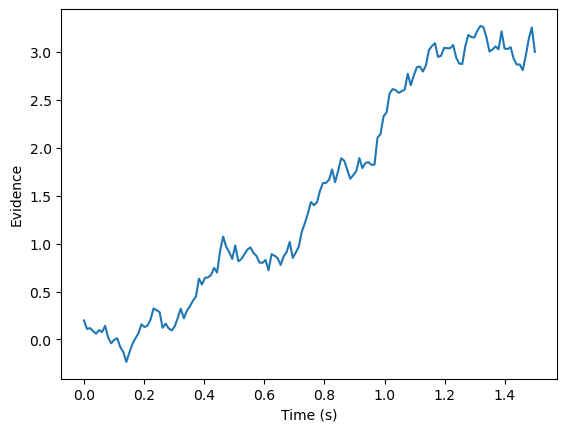

In [2]:
def evidence_accumulation(nu, max_t=1.5, dt=0.01):
    timesteps = int(max_t / dt)
    t = np.linspace(0, max_t, timesteps)

    noise = np.random.normal(0, 1, size=timesteps) * np.sqrt(dt)
    evidence = nu * t + np.cumsum(noise)

    return t, evidence

t, evidence = evidence_accumulation(nu=2.5)

plt.plot(t, evidence)
plt.xlabel("Time (s)")
plt.ylabel("Evidence")

In [3]:
def context(batch_size, n_trials=None):
    if n_trials is None:
        n_trials = np.random.randint(200, 351)
    return dict(n_trials=n_trials)

def prior():
    nu=np.random.gamma(shape=10, scale=0.25)
    alpha=np.random.gamma(shape=10, scale=0.1)

    return dict(nu=nu, alpha=alpha)

def trial(nu, alpha):
    max_t = 1.5
    t, evidence = evidence_accumulation(nu)
    rt = next((t for t, ev in zip(t, evidence) if ev > alpha), max_t)

    return rt

def likelihood(nu, alpha, n_trials):
    rt = np.zeros(n_trials)
    for i in range(n_trials):
        rt[i] = trial(nu, alpha)

    return dict(rt=rt)

def summary(rt):
    return dict(
        mean = np.mean(rt),
        sd = np.std(rt)
    )


simulator = bf.make_simulator([prior, likelihood, summary], meta_fn = context)

In [4]:
df = simulator.sample(500)

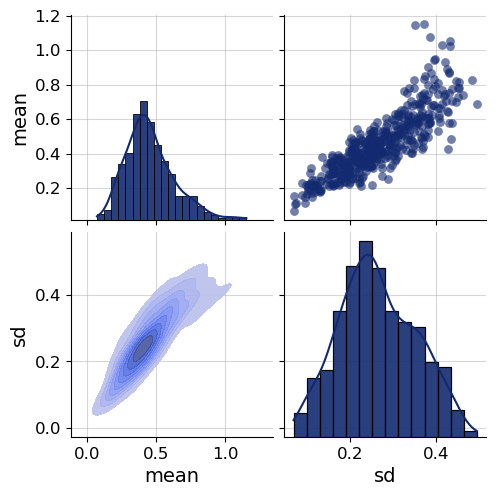

In [5]:
bf.diagnostics.pairs_samples(df, variable_keys=["mean", "sd"])

In [6]:
adapter = (bf.Adapter()
    .broadcast("n_trials", to="nu")
    .constrain(["nu", "alpha"], lower=0)
    .drop("rt")
    .concatenate(["n_trials", "mean", "sd"], into="inference_conditions")
    .concatenate(["nu", "alpha"], into="inference_variables")
)

In [ ]:
workflow = bf.BasicWorkflow(
    simulator = simulator,
    adapter = adapter,
    inference_network = bf.networks.CouplingFlow(permutation="swap", subnet_kwargs=dict(dropout=False)),
    inference_variables = ["nu", "alpha"],
)

In [ ]:
history=workflow.fit_online(epochs=50, num_batches_per_epoch=50, batch_size=64)

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 248ms/step - loss: 3.1967 - loss/inference_loss: 3.1967
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step - loss: 2.3166 - loss/inference_loss: 2.3166
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step - loss: 2.2775 - loss/inference_loss: 2.2775
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - loss: 2.1968 - loss/inference_loss: 2.1968
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 243ms/step - loss: 2.2096 - loss/inference_loss: 2.2096
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step - loss: 2.1236 - loss/inference_loss: 2.1236
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - loss: 2.1516 - loss/inference_loss: 2.1516
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - loss: 2.1256 - loss/inference_loss: 2.1256
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 243ms/step - loss: 2.1083 - loss/inference_loss: 2.1083
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - loss: 2.0685 - loss/inference_loss: 2.0685


In [9]:
df = simulator.sample(500, n_trials=250)

In [10]:
prior = dict(nu = df["nu"], alpha = df["alpha"])

In [11]:
posterior = workflow.sample(num_samples=100, conditions=df)

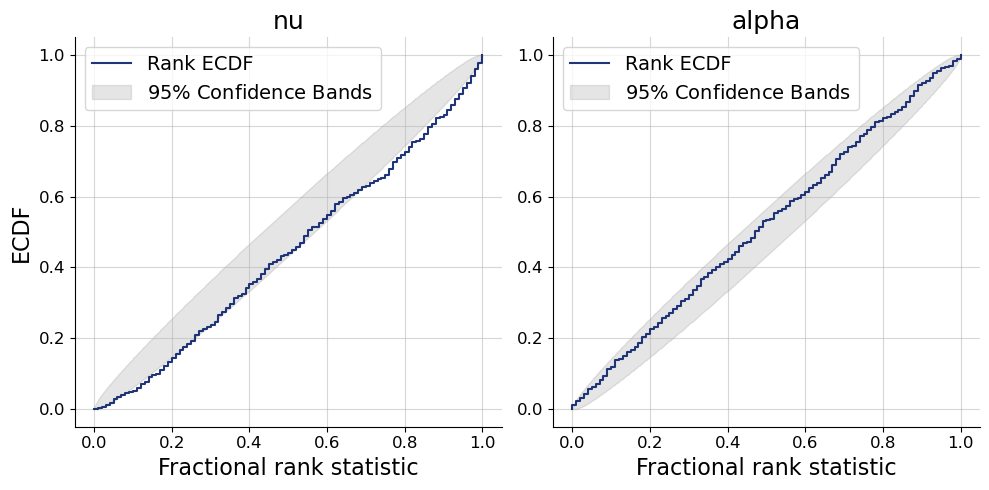

In [12]:
fig=bf.diagnostics.plots.calibration_ecdf(estimates=posterior, targets=prior)

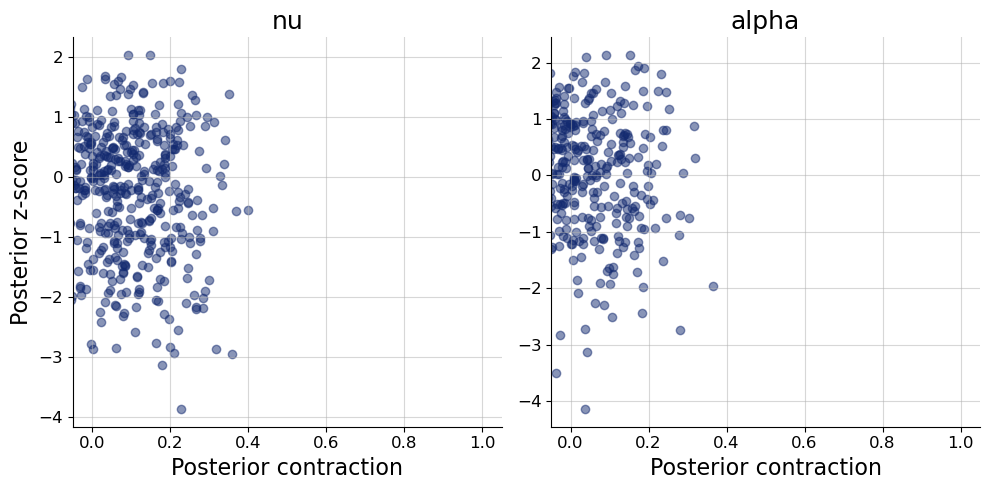

In [13]:
fig=bf.diagnostics.z_score_contraction(estimates=posterior, targets=prior)

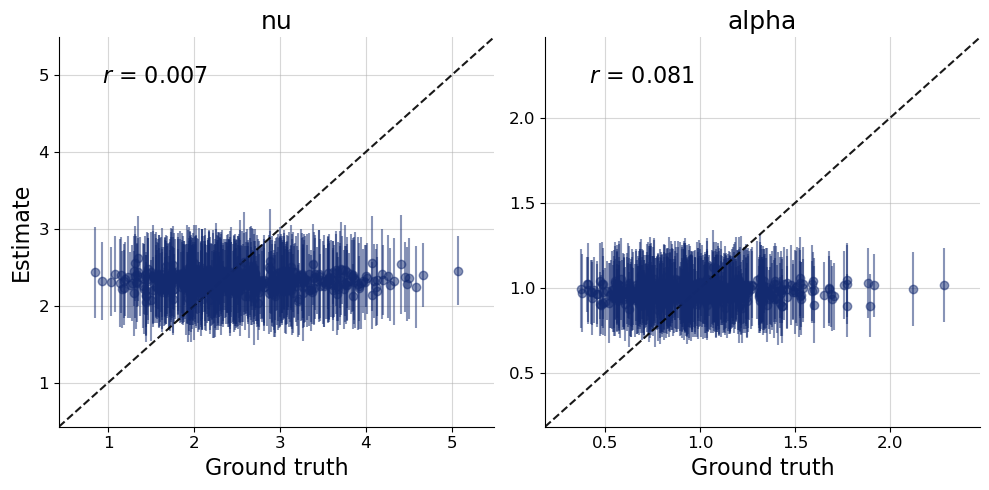

In [14]:
fig=bf.diagnostics.plots.recovery(estimates=posterior, targets=prior)

In [15]:
def context(batch_size, n_trials=None):
    if n_trials is None:
        n_trials = np.random.randint(200, 351)
    return dict(n_trials=n_trials)

def prior():
    nu=np.random.gamma(shape=20, scale=0.125)
    nu_correct=np.random.gamma(shape=20, scale=0.125)
    alpha=np.random.gamma(shape=10, scale=0.1)
    tau=np.random.exponential(0.2)

    return dict(nu=nu, nu_correct=nu_correct, alpha=alpha, tau=tau)

def trial(nu, nu_correct, alpha, tau):
    max_t = 1.5

    t, evidence = evidence_accumulation(nu+nu_correct)
    t_correct = next((t for t, ev in zip(t, evidence) if ev > alpha), max_t)

    t, evidence = evidence_accumulation(nu)
    t_error = next((t for t, ev in zip(t, evidence) if ev > alpha), max_t)


    if t_correct < t_error:
        rt = t_correct + tau
        choice = 0
    else:
        rt = t_error + tau
        choice = 1

    return rt, choice

def likelihood(nu, nu_correct, alpha, tau, n_trials):
    rts = np.zeros(n_trials)
    choices = np.zeros(n_trials)
    for i in range(n_trials):
        rt, choice = trial(nu, nu_correct, alpha, tau)
        rts[i] = rt
        choices[i] = choice

    return dict(rt=rts, choice=choices)

simulator = bf.make_simulator([prior, likelihood], meta_fn=context)